In [ ]:
from google.colab import drive
import os

# 1. Mount Google Drive
drive.mount('/content/drive')

# ==========================================
# [Please modify here] Your project path
# ==========================================
project_path = '/content/drive/MyDrive/bosch/TS-TCC'

# 2. Change working directory
try:
    os.chdir(project_path)
    print(f"Successfully changed directory to: {os.getcwd()}")
except FileNotFoundError:
    print("❌ Path not found! Please check if project_path is correct.")

# 3. Verify required files exist
if not os.path.exists('data_preprocessing/PSM/train.csv'):
    print("⚠️ Warning: train.csv not found in data_preprocessing/PSM/, please confirm files are uploaded.")
else:
    print("✅ File check OK: train.csv found")

# 4. Install dependencies (usually Colab defaults are sufficient, but just in case)
!pip install torch numpy pandas scikit-learn

Mounted at /content/drive
成功切換目錄至: /content/drive/MyDrive/bosch/TS-TCC
✅ 檔案檢查 OK：找到 train.csv


In [ ]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    print(f"✅ GPU ready: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️ Warning: Currently using CPU, training will be slow! Please go to Runtime -> Change runtime type to enable GPU.")

# Start training
# --home_path . ensures it looks for data in the current directory
print("🚀 Starting TS-TCC model training...")
!python main.py --run_description "trial2" --selected_dataset PSM --device cuda --home_path . --training_mode self_supervised

✅ GPU 準備就緒: Tesla T4
🚀 開始訓練 TS-TCC 模型...
Dataset: PSM
Method:  TS-TCC
Mode:    self_supervised
Loading data from: ./data/PSM
正在從 ./data/PSM 加載數據...
  train.pt: samples shape=torch.Size([10589, 25, 100]), labels shape=torch.Size([10589])
  val.pt: samples shape=torch.Size([2640, 25, 100]), labels shape=torch.Size([2640])
  test.pt: samples shape=torch.Size([878, 25, 100]), labels shape=torch.Size([878])
Data loaded ...
Training started ....

Epoch 1/40 (2.5%)

Epoch : 1
Train Loss     : 3.6426	 | 	Train Accuracy     : N/A (Self-Supervised)
Valid Loss     : 0.0000	 | 	Valid Accuracy     : N/A (Self-Supervised)
Train Loss     : 3.6426	 | 	Train Accuracy     : N/A (Self-Supervised)
Valid Loss     : 0.0000	 | 	Valid Accuracy     : N/A (Self-Supervised)

Epoch 2/40 (5.0%)

Epoch : 2
Train Loss     : 2.2306	 | 	Train Accuracy     : N/A (Self-Supervised)
Valid Loss     : 0.0000	 | 	Valid Accuracy     : N/A (Self-Supervised)
Train Loss     : 2.2306	 | 	Train Accuracy     : N/A (Self-Supervised)

Evaluation

Using device: cuda
📂 正在搜尋 experiments_logs 下最新的模型權重...
✅ 找到最新權重: experiments_logs/Exp1/trial2/self_supervised_seed_0/saved_models/ckp_last.pt
📦 載入預處理數據...
🧠 正在提取特徵向量 (Inference)...
  Train features shape: torch.Size([10589, 128])
  Test features shape: torch.Size([878, 128])
📉 計算異常分數...

🚀 開始評估 (Point Adjustment Mode)
🔍 正在搜索最佳閾值 (範圍: 0.2095 ~ 0.5467)...

🏆 最終結果 (Final Result)
Best F1-Score : 0.8161
Precision     : 0.8351
Recall        : 0.7979
Best Threshold: 0.432079
AUROC (Raw)   : 0.6228
📊 正在繪製結果圖...
✅ 結果圖已儲存為: anomaly_detection_result.png


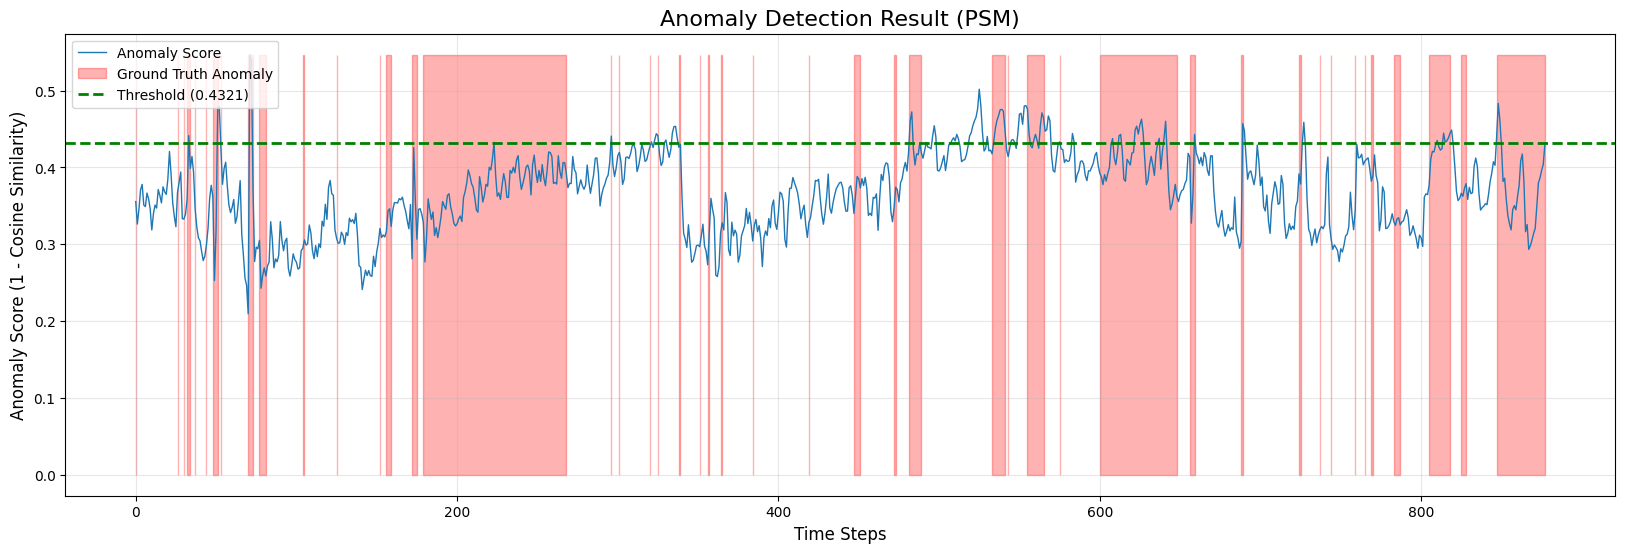

In [ ]:
import torch
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from config_files.PSM_Configs import Config
from models.model import base_Model

# ==========================================
# Part 1: Evaluation Utility Functions (Point Adjustment)
# ==========================================

def calc_point2point(predict, actual):
    """
    Calculate F1, Precision, Recall
    """
    TP = np.sum(predict * actual)
    TN = np.sum((1 - predict) * (1 - actual))
    FP = np.sum(predict * (1 - actual))
    FN = np.sum((1 - predict) * actual)
    precision = TP / (TP + FP + 0.00001)
    recall = TP / (TP + FN + 0.00001)
    f1 = 2 * precision * recall / (precision + recall + 0.00001)
    return f1, precision, recall

def adjust_predicts(score, label, threshold=None, pred=None):
    """
    Point Adjustment core logic:
    If any point within an anomaly interval is detected, the entire interval is considered correctly detected.
    """
    if pred is None:
        predict = score > threshold
    else:
        predict = pred
    actual = label > 0.1
    anomaly_state = False

    for i in range(len(score)):
        if actual[i] and predict[i] and not anomaly_state:
                anomaly_state = True
                for j in range(i, 0, -1):
                    if not actual[j]:
                        break
                    else:
                        if not predict[j]:
                            predict[j] = True
        elif not actual[i]:
            anomaly_state = False
        if anomaly_state:
            predict[i] = True
    return predict

def bf_search(score, label, start, end, step_num=100, verbose=True):
    """
    Brute force search for the best F1-Score threshold
    """
    print(f"🔍 Searching for best threshold (range: {start:.4f} ~ {end:.4f})...")
    search_range = end - start
    m = (-1., -1., -1.) # Best (F1, Precision, Recall)
    m_t = 0.0           # Best Threshold

    for i in range(step_num):
        threshold = start + (search_range * i / step_num)
        pred = adjust_predicts(score, label, threshold)
        target = calc_point2point(pred, label)

        # target[0] is F1-Score
        if target[0] > m[0]:
            m_t = threshold
            m = target

    return m, m_t

# ==========================================
# Part 2: Main Program (Auto-loading and Visualization)
# ==========================================

def main():
    # 1. Environment setup
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    if not os.path.exists('config_files/PSM_Configs.py'):
        print("❌ Config file not found! Please confirm you are in the correct project directory.")
        return

    configs = Config()
    model = base_Model(configs).to(device)

    # -------------------------------------------------------------------
    # 2. Automatically find latest checkpoint (Robust Path Finding)
    # -------------------------------------------------------------------
    exp_dir = 'experiments_logs'
    model_path = None

    print("📂 Searching for latest model weights in experiments_logs...")

    # Search for all possible .chkpt or .pt files (recursive search)
    # Format is usually: experiments_logs/ExpName/checkpoints/model.chkpt
    search_patterns = [
        os.path.join(exp_dir, "**", "*.chkpt"),
        os.path.join(exp_dir, "**", "*.pt")
    ]

    found_files = []
    for pattern in search_patterns:
        found_files.extend(glob.glob(pattern, recursive=True))

    # Filter out .pt files in data folder, keep only those in experiments_logs
    found_checkpoints = [f for f in found_files if "experiments_logs" in f]

    if not found_checkpoints:
        print(f"❌ No weight files found in {exp_dir}! Please confirm training completed successfully.")
        return

    # Find the file with the latest modification time
    latest_checkpoint = max(found_checkpoints, key=os.path.getmtime)
    print(f"✅ Found latest weights: {latest_checkpoint}")

    try:
        checkpoint = torch.load(latest_checkpoint, map_location=device)
        # Handle different storage formats (some store entire dict, some only state_dict)
        if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
        else:
            model.load_state_dict(checkpoint)
    except Exception as e:
        print(f"⚠️ Loading failed: {e}")
        return

    model.eval()

    # 3. Load data
    print("📦 Loading preprocessed data...")
    try:
        train_data = torch.load('data/PSM/train.pt')['samples'].to(device)
        test_dict  = torch.load('data/PSM/test.pt')
        X_test = test_dict['samples'].to(device)
        y_test = test_dict['labels'].numpy() # Ground truth labels
    except FileNotFoundError:
        print("❌ Data files not found (data/PSM/*.pt).")
        return

    # 4. 提取特徵 (Inference)
    # print("🧠 正在提取特徵向量 (Inference)...")
    # with torch.no_grad():
    #     train_feats, _ = model(train_data)
    #     test_feats, _  = model(X_test)
    # 4. 提取特徵 (Inference) - 使用正確的特徵提取方式
    # print("🧠 正在提取特徵向量 (Inference)...")

    # batch_size = 64
    # train_feats_list = []
    # test_feats_list = []

    # with torch.no_grad():
    #     # 處理訓練數據（批次處理避免內存問題）
    #     for i in range(0, len(train_data), batch_size):
    #         batch = train_data[i:i+batch_size]
    #         _, features = model(batch)  # ⚠️ 關鍵：使用第二個返回值（卷積特徵），不是 logits！
    #         # features shape: (batch, channels, seq_len)
    #         # 對時間維度進行 Max pooling（捕捉最顯著的特徵）
    #         features_pooled = torch.max(features, dim=2)[0]  # (batch, channels)
    #         train_feats_list.append(features_pooled.cpu())

    #     # 處理測試數據
    #     for i in range(0, len(X_test), batch_size):
    #         batch = X_test[i:i+batch_size]
    #         _, features = model(batch)  # ⚠️ 關鍵：使用第二個返回值
    #         features_pooled = torch.max(features, dim=2)[0]
    #         test_feats_list.append(features_pooled.cpu())

    # train_feats = torch.cat(train_feats_list, dim=0).to(device)
    # test_feats = torch.cat(test_feats_list, dim=0).to(device)

    # print(f"  Train features shape: {train_feats.shape}")
    # print(f"  Test features shape: {test_feats.shape}")

    # # 檢查並處理 NaN/Inf
    # if torch.isnan(train_feats).any() or torch.isinf(train_feats).any():
    #     print("⚠️ 警告：特徵中包含 NaN/Inf，將進行處理...")
    #     train_feats = torch.nan_to_num(train_feats)
    #     test_feats = torch.nan_to_num(test_feats)

    # 4. Extract features (Inference) - Using correct feature extraction method
    print("🧠 Extracting feature vectors (Inference)...")

    batch_size = 64
    train_feats_list = []
    test_feats_list = []

    with torch.no_grad():
        # Process training data (batch processing to avoid memory issues)
        for i in range(0, len(train_data), batch_size):
            batch = train_data[i:i+batch_size]
            _, features = model(batch)  # ⚠️ Key: Use second return value (convolutional features)
            # features shape: (batch, channels, seq_len)
            # Apply Mean pooling on temporal dimension
            features_pooled = torch.mean(features, dim=2)  # (batch, channels)
            train_feats_list.append(features_pooled.cpu())

        # Process test data
        for i in range(0, len(X_test), batch_size):
            batch = X_test[i:i+batch_size]
            _, features = model(batch)  # ⚠️ Key: Use second return value
            features_pooled = torch.mean(features, dim=2)  # Mean pooling
            test_feats_list.append(features_pooled.cpu())

    train_feats = torch.cat(train_feats_list, dim=0).to(device)
    test_feats = torch.cat(test_feats_list, dim=0).to(device)

    print(f"  Train features shape: {train_feats.shape}")
    print(f"  Test features shape: {test_feats.shape}")

    # Check and handle NaN/Inf
    if torch.isnan(train_feats).any() or torch.isinf(train_feats).any():
        print("⚠️ Warning: Features contain NaN/Inf, processing...")
        train_feats = torch.nan_to_num(train_feats)
        test_feats = torch.nan_to_num(test_feats)

    # 5. Calculate anomaly scores (Cosine Distance)
    print("📉 Calculating anomaly scores...")
    center = torch.mean(train_feats, dim=0)
    cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
    similarity = cos(test_feats, center.unsqueeze(0))
    anomaly_scores = 1 - similarity.cpu().numpy()

    # 6. Perform search and evaluation
    print("\n" + "="*40)
    print("🚀 Starting evaluation (Point Adjustment Mode)")
    print("="*40)

    best_metrics, best_thresh = bf_search(
        score=anomaly_scores,
        label=y_test,
        start=np.min(anomaly_scores),
        end=np.max(anomaly_scores),
        step_num=100
    )

    best_f1, best_precision, best_recall = best_metrics

    print("\n" + "="*40)
    print(f"🏆 最終結果 (Final Result)")
    print("="*40)
    print(f"Best F1-Score : {best_f1:.4f}")
    print(f"Precision     : {best_precision:.4f}")
    print(f"Recall        : {best_recall:.4f}")
    print(f"Best Threshold: {best_thresh:.6f}")
    print(f"AUROC (Raw)   : {roc_auc_score(y_test, anomaly_scores):.4f}")
    print("="*40)

    # 7. Visualization - Chart functionality
    print("📊 Plotting results...")
    plt.figure(figsize=(20, 6))

    # Plot anomaly scores
    plt.plot(anomaly_scores, label='Anomaly Score', color='#1f77b4', linewidth=1)

    # Plot ground truth anomaly intervals (red background)
    # Extend labels to chart height for better observation
    max_score = np.max(anomaly_scores)
    plt.fill_between(range(len(y_test)), 0, max_score,
                     where=(y_test==1), color='red', alpha=0.3, label='Ground Truth Anomaly')

    # Plot best threshold line
    plt.axhline(y=best_thresh, color='green', linestyle='--', linewidth=2, label=f'Threshold ({best_thresh:.4f})')

    plt.title('Anomaly Detection Result (PSM)', fontsize=16)
    plt.xlabel('Time Steps', fontsize=12)
    plt.ylabel('Anomaly Score (1 - Cosine Similarity)', fontsize=12)
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)

    save_path = 'anomaly_detection_result.png'
    plt.savefig(save_path)
    print(f"✅ Result plot saved as: {save_path}")
    # plt.show() # Uncomment if you want to display directly in Colab

if __name__ == '__main__':
    main()